In [2]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel,preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
import random
from imutils import paths

In [3]:
data_dir = os.path.join(os.getcwd(), 'data')
out_dir = os.path.join(os.getcwd(), 'output')

In [4]:
IMAGE_SIZE = [200, 200]

In [5]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

In [6]:
ptm.trainable = False

In [7]:
imagePaths = sorted(list(paths.list_images(data_dir)))
random.seed(2)
random.shuffle(imagePaths)

In [8]:
K = 2 # number of classes
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

In [9]:
model = Model(inputs=ptm.input, outputs=x)

In [10]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)      

In [11]:
train_path = 'data/train'
valid_path = 'data/test'

In [12]:
gen_train = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  preprocessing_function=preprocess_input
)

gen_test = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [13]:
batch_size = 128

# create generators
train_generator = gen_train.flow_from_directory(
  train_path,
  shuffle=True,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)
valid_generator = gen_test.flow_from_directory(
  valid_path,
  shuffle = False,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)

Found 716 images belonging to 2 classes.
Found 371 images belonging to 2 classes.


In [14]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [15]:
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [16]:
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=10,
  steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
  validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10


/home/ravikant/.local/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


6/6 [==============================] - 125s 21s/step - loss: 7.6639 - accuracy: 0.6718 - val_loss: 6.3131 - val_accuracy: 0.8571
Epoch 2/10
6/6 [==============================] - 128s 21s/step - loss: 2.7305 - accuracy: 0.9050 - val_loss: 7.5429e-04 - val_accuracy: 1.0000
Epoch 3/10
6/6 [==============================] - 130s 22s/step - loss: 0.2979 - accuracy: 0.9749 - val_loss: 1.4103 - val_accuracy: 0.9515
Epoch 4/10
6/6 [==============================] - 138s 23s/step - loss: 0.4121 - accuracy: 0.9693 - val_loss: 0.1956 - val_accuracy: 0.9784
Epoch 5/10
6/6 [==============================] - 143s 24s/step - loss: 0.0177 - accuracy: 0.9972 - val_loss: 3.2132e-09 - val_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 139s 23s/step - loss: 1.6758e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 141s 24s/step - loss: 5.3535e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8

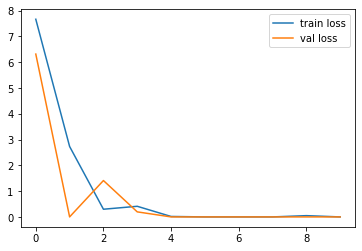

In [17]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

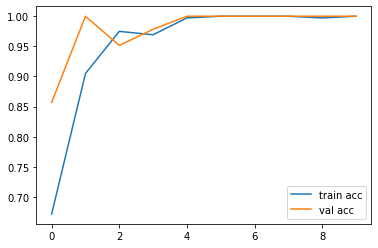

In [18]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [19]:
model_path = os.path.join(out_dir,  'trained_VGG_model.h5')
model.save(model_path)

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
predIdxs=model.predict_generator(valid_generator)
predIdxs = np.argmax(predIdxs, axis=1)

print('Confusion Matrix')
print(confusion_matrix(valid_generator.labels, predIdxs))

print(classification_report(valid_generator.labels, predIdxs,
                            target_names=["apple", "non-apple"]))

/home/ravikant/.local/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Confusion Matrix
[[212   0]
 [  0 159]]
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00       212
   non-apple       1.00      1.00      1.00       159

    accuracy                           1.00       371
   macro avg       1.00      1.00      1.00       371
weighted avg       1.00      1.00      1.00       371

